# ANN to predict ETF value

The ANN should learn from various titles based on many features

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np


data = []  # Lista per salvare i dati
etf_tickers = ["SPY", "QQQ", "VTI", "EEM", "EFA"]  # Lista ETF
period = "20y"  # Periodo dati storici

# Scarica i dati per ogni ETF
for i, ticker in enumerate(etf_tickers):
    etf = yf.Ticker(ticker)
    df = etf.history(period=period)  # Dati storici
    df['ETF_ID'] = i  # Assegna un ID numerico all'ETF
    data.append(df)  
    df.to_csv(f"{ticker}.csv")  # Salva il CSV
    print(f"Dati di {ticker} salvati con successo!")

print("Download completato.")

Dati di SPY salvati con successo!
Dati di QQQ salvati con successo!
Dati di VTI salvati con successo!
Dati di EEM salvati con successo!
Dati di EFA salvati con successo!
Download completato.


# FEATURE ENGINEERING

new features added = ['Pct_Change', 'MA_10', 'MA_50', 'Volatility_10', 'Volume_Norm', 'RSI_14']

In [2]:
# FEATURE ENGINEERING

features = ['ETF_ID', 'Pct_Change', 'MA_10', 'MA_50', 'Volatility_10', 'Volume_Norm', 'RSI_14']

# Funzione per calcolare l'RSI
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Aggiungi variazione percentuale del prezzo


data_pct_change = []

for i in range (len(data)):
    data_pct_change.append(0)
    for x in range(1,len(data[i]['Close'])):
        data_pct_change.append(data[i]['Close'].iloc[x] / data[i]['Close'].iloc[x-1])

print(len(data_pct_change))


for i in range(len(data)):

    #data[i]['ETF_ID'] = i
    data[i] = data[i].copy()  # Evita il SettingWithCopyWarning
    data[i]['Pct_Change'] = data[i]['Close'].pct_change().astype(np.float64)

    data[i].loc[:, 'Pct_Change'] = data_pct_change[i*len(data[i]['Close']):(i+1)*len(data[i]['Close'])]

    # Aggiungi la media mobile a 10 e 50 giorni
    data[i]['MA_10'] = data[i]['Close'].rolling(window=10).mean()
    data[i]['MA_50'] = data[i]['Close'].rolling(window=50).mean()

    # Aggiungi la volatilità (deviazione standard su 10 giorni)
    data[i]['Volatility_10'] = data[i]['Close'].rolling(window=10).std()

    # Normalizza il volume per evitare valori troppo grandi
    data[i]['Volume_Norm'] = data[i]['Volume'] / data[i]['Volume'].rolling(window=10).mean()
    
    # Aggiungi RSI con finestra di 14 giorni
    data[i]['RSI_14'] = compute_rsi(data[i]['Close'])

    # Rimuove i NaN e mantiene ETF_ID
    data[i] = data[i].dropna().reset_index()
        


25165


## To verify what to keep and what to trash

In [3]:
split_ratio_train = 0.8
split_ratio_valid = 0.9  # 80% train, 10% valid, 10% test

train_data = []
valid_data = []
test_data = []

for i in range(len(data)):
    dataset = data[i]  # Prendi il dataset dell'ETF i-esimo
    split_idx1 = int(len(dataset) * split_ratio_train)
    split_idx2 = int(len(dataset) * split_ratio_valid)
    
    train_data.append(dataset.iloc[:split_idx1])   # Dati di training (80%)
    valid_data.append(dataset.iloc[split_idx1:split_idx2])  # Dati di validazione (10%)
    test_data.append(dataset.iloc[split_idx2:])   # Dati di test (10%)

    print(f"Dataset {i}: Train {len(train_data[i])}, Valid {len(valid_data[i])}, Test {len(test_data[i])}")


Dataset 0: Train 3987, Valid 498, Test 499
Dataset 1: Train 3987, Valid 498, Test 499
Dataset 2: Train 3987, Valid 498, Test 499
Dataset 3: Train 3987, Valid 498, Test 499
Dataset 4: Train 3987, Valid 498, Test 499


# Da rifare a partire da qui, data non deve contenere solo la variazione percentuale

In [4]:
import numpy as np
import pandas as pd

# Configurazione della finestra temporale
window = 15

def create_sequences(data_list, window):
    x, y = [], []
    
    for etf_id, dataset in enumerate(data_list):  # Itera su ogni ETF
        data = dataset[features].values  # Mantiene i tipi originali

        for i in range(len(data) - window):           
            x.append(data[i:i+window, :])
            y.append(data[i+window, :])    # Predizione basata sulla prima feature (es. Close)

    return np.array(x), np.array(y)  



# Crea le sequenze temporali per ogni set
x_train, y_train = create_sequences(train_data, window)
x_valid, y_valid = create_sequences(valid_data, window)
x_test, y_test = create_sequences(test_data, window)


# Numero di feature
num_features = len(features)  # Aggiunta dell’ID ETF
print(num_features)

# Reshape per adattare alla LSTM
x_train = x_train.reshape((x_train.shape[0], window, num_features))
x_valid = x_valid.reshape((x_valid.shape[0], window, num_features))
x_test = x_test.reshape((x_test.shape[0], window, num_features))


# Stampa delle forme dei set
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_valid shape: {x_valid.shape}, y_valid shape: {y_valid.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")


7
x_train shape: (19860, 15, 7), y_train shape: (19860, 7)
x_valid shape: (2415, 15, 7), y_valid shape: (2415, 7)
x_test shape: (2420, 15, 7), y_test shape: (2420, 7)


In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import pandas as pd

# StandardScaler per Pct_Change, MA_10, MA_50, Volatility_10, Volume_Norm
scaler_standard = StandardScaler()

# MinMaxScaler per RSI_14
scaler_minmax = MinMaxScaler(feature_range=(0, 1))

# Funzione per scalare i dati
def scale_data(train, valid, test, scaler, feature_idx):
    """
    Applica lo scaler ai dataset di training, validazione e test.
    
    :param train: Lista di DataFrame (train set)
    :param valid: Lista di DataFrame (valid set)
    :param test: Lista di DataFrame (test set)
    :param scaler: Istanza dello scaler da applicare
    :param feature_idx: Indici delle feature da scalare
    :return: Versioni scalate dei dataset
    """
    # Unisce tutti i dataset per ottenere le statistiche corrette
    full_train = pd.concat(train)

    # Adatta lo scaler solo sui dati di training
    scaler.fit(full_train.iloc[:, feature_idx])

    # Trasforma ogni dataset
    train_scaled = [scaler.transform(df.iloc[:, feature_idx]) for df in train]
    valid_scaled = [scaler.transform(df.iloc[:, feature_idx]) for df in valid]
    test_scaled = [scaler.transform(df.iloc[:, feature_idx]) for df in test]

    return train_scaled, valid_scaled, test_scaled

# Indici delle feature da scalare
features_standard = ['MA_10', 'MA_50', 'Volatility_10', 'Volume_Norm']
features_minmax = ['RSI_14']

# Applica StandardScaler
train_scaled_std, valid_scaled_std, test_scaled_std = scale_data(train_data, valid_data, test_data, scaler_standard, 
                                                                 [features.index(f) for f in features_standard])

# Applica MinMaxScaler
train_scaled_minmax, valid_scaled_minmax, test_scaled_minmax = scale_data(train_data, valid_data, test_data, scaler_minmax, 
                                                                         [features.index(f) for f in features_minmax])

# Ricostruisce i dataset scalati
for i in range(len(train_data)):
    train_data[i].iloc[:, [features.index(f) for f in features_standard]] = train_scaled_std[i]
    valid_data[i].iloc[:, [features.index(f) for f in features_standard]] = valid_scaled_std[i]
    test_data[i].iloc[:, [features.index(f) for f in features_standard]] = test_scaled_std[i]
    
    train_data[i].iloc[:, [features.index(f) for f in features_minmax]] = train_scaled_minmax[i]
    valid_data[i].iloc[:, [features.index(f) for f in features_minmax]] = valid_scaled_minmax[i]
    test_data[i].iloc[:, [features.index(f) for f in features_minmax]] = test_scaled_minmax[i]

# Crea le sequenze temporali per LSTM
x_train, y_train = create_sequences(train_data, window)
x_valid, y_valid = create_sequences(valid_data, window)
x_test, y_test = create_sequences(test_data, window)

# Reshape per LSTM
x_train = x_train.reshape((x_train.shape[0], window, num_features))
x_valid = x_valid.reshape((x_valid.shape[0], window, num_features))
x_test = x_test.reshape((x_test.shape[0], window, num_features))

# Stampa delle forme finali
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_valid shape: {x_valid.shape}, y_valid shape: {y_valid.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")


x_train shape: (19860, 15, 7), y_train shape: (19860, 7)
x_valid shape: (2415, 15, 7), y_valid shape: (2415, 7)
x_test shape: (2420, 15, 7), y_test shape: (2420, 7)


In [8]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization, Bidirectional, Attention, Input, LayerNormalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import tensorflow as tf

skipTraining = False


class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def call(self, inputs):
        query, value = inputs, inputs
        attention_scores = tf.matmul(query, value, transpose_b=True)
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)
        return tf.matmul(attention_scores, value)

    def get_config(self):
        config = super(AttentionLayer, self).get_config()
        return config

    

# Creazione del modello LSTM avanzato
model = Sequential()

# Bidirectional LSTM
model.add(Bidirectional(LSTM(units=256, return_sequences=True, activation="tanh"), input_shape=(window, num_features)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Secondo LSTM
model.add(LSTM(units=128, return_sequences=True, activation="tanh"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# GRU Layer (migliora la cattura di dipendenze a lungo termine)
model.add(GRU(units=128, return_sequences=True, activation="tanh"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Attention Layer
model.add(AttentionLayer())

# Ultimo strato LSTM prima dei densi
model.add(LSTM(units=64, return_sequences=False, activation="tanh"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Strati Fully Connected (Dense)
model.add(Dense(units=128, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(units=64, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(units=32, activation="relu"))
model.add(Dropout(0.1))

# Output
model.add(Dense(units=num_features))

# Compilazione del modello con AdamW e Huber loss
optimizer = AdamW(learning_rate=0.001, weight_decay=1e-5)
model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-5, verbose=1)

if not skipTraining:
    # Addestramento del modello
    hist = model.fit(
        x_train, y_train,
        epochs=350,
        batch_size=32,
        validation_data=(x_valid, y_valid),
        callbacks=[lr_scheduler]
    )

    # Salvataggio del modello
    model.save("etf_model_advanced_v2.h5")

else:
    model = keras.models.load_model(
        "etf_model_advanced_v2.h5",
        custom_objects={"AttentionLayer": AttentionLayer},
        compile=False
    )
    
    # Ricompila il modello con la stessa funzione di perdita
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])



c:\Users\sfori\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/350
621/621 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - loss: 14.4405 - mae: 14.9034 - root_mean_squared_error: 31.1427 - val_loss: 13.5589 - val_mae: 13.9628 - val_root_mean_squared_error: 34.9134 - learning_rate: 0.0010
Epoch 2/350
621/621 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - loss: 6.0299 - mae: 6.4287 - root_mean_squared_error: 14.0678 - val_loss: 17.2241 - val_mae: 17.5955 - val_root_mean_squared_error: 40.8377 - learning_rate: 0.0010
Epoch 3/350
621/621 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - loss: 5.2970 - mae: 5.6534 - root_mean_squared_error: 12.5996 - val_loss: 9.4418 - val_mae: 9.7986 - val_root_mean_squared_error: 24.1063 - learning_rate: 0.0010
Epoch 4/350
621/621 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - loss: 5.0247 - mae: 5.3747 - root_mean_squared_error: 11.8351 - val_loss: 10.3805 - val_mae: 10.7615 - val_root_mean_squared_error: 23.0072 - learning_rate: 0.0010
Epoch 5/350
621/621 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - loss: 4.8815 - mae: 5.2240 - root_mean_squared_error: 11.73

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 11.7195 - mae: 12.0809 - root_mean_squared_error: 24.5829
[6.384088039398193, 6.731508731842041, 16.877361297607422]


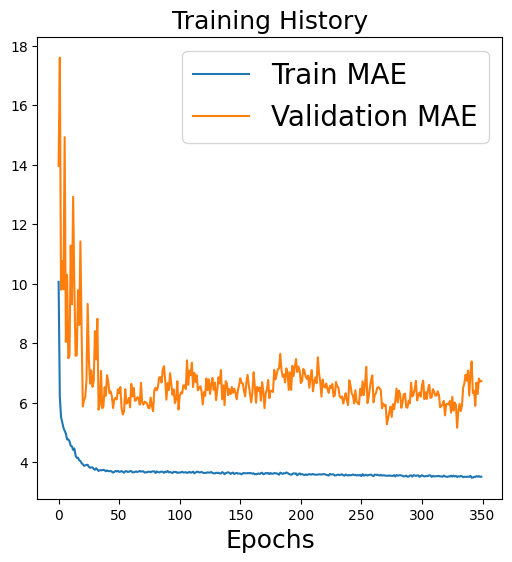

In [9]:
import matplotlib.pyplot as plt
# plot training epochs

fig, axes = plt.subplots(figsize=(6,6))

plt.plot(hist.history['mae'], label="Train MAE")
plt.plot(hist.history['val_mae'], label="Validation MAE")
axes.set_title("Training History", fontsize=18)
axes.set_xlabel("Epochs", fontsize=18)
axes.legend(fontsize=20)

# Final accuracy
print ( model.evaluate(x_valid, y_valid))

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
1.0039678
4.78495125049983
4.927795896832274


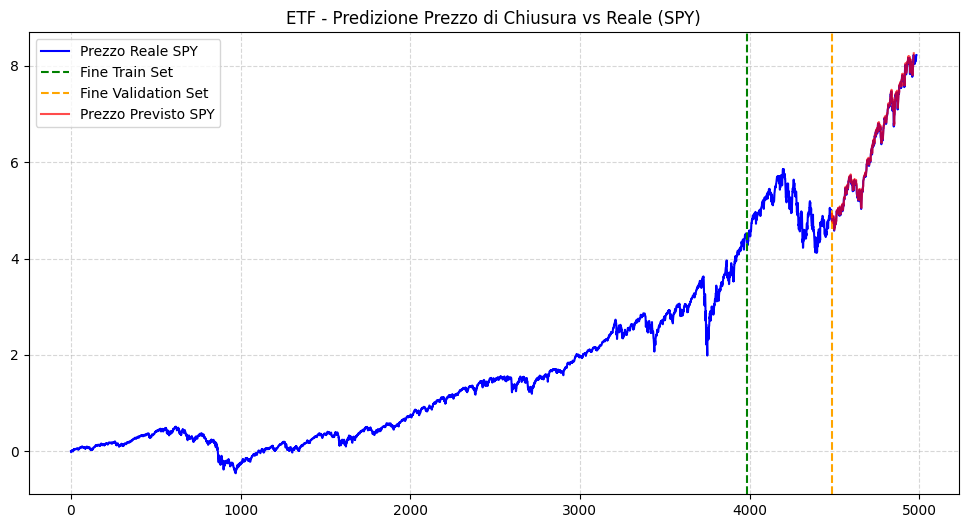

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#['ETF_ID', 'Pct_Change', 'MA_10', 'MA_50', 'Volatility_10', 'Volume_Norm', 'RSI_14']

# Seleziona l'ETF_ID corrispondente a SPY (ETF 0)

def create_data_etf(data_test, etf_id):
    test_data_etf = []
    for i in range(len(data_test)):
        if(int(data_test[i]['ETF_ID']) == etf_id):
            test_data_etf.append(data_test[i])
    return test_data_etf

# Ottieni le predizioni per tutte le feature
y_pred = model.predict(x_test)

spy_id = 0
dataset_spy = data[spy_id]['Close']
test_data_spy = test_data[spy_id]
valid_data_spy = valid_data[spy_id]

#Work around per problema della rete -> FUCK
for i in range(len(y_pred)):
    y_pred[i][0] = y_test[i][0]

y_pred_pctChange_spy = []
for i in range(len(y_pred)):
    if(y_pred[i][0] == spy_id):
        y_pred_pctChange_spy.append(y_pred[i][1])

print(y_pred_pctChange_spy[0])

y_pred_close_spy = []
#First value
last_value = valid_data_spy['Close'].iloc[-1]
y_pred_close_spy.append(y_pred_pctChange_spy[0] * last_value)

for i in range(1,len(y_pred_pctChange_spy)):
    y_pred_close_spy.append(y_pred_pctChange_spy[i] * test_data_spy['Close'].iloc[i-1])

print(test_data_spy['Close'].iloc[0])
print(y_pred_close_spy[0])

# **Grafico**
fig, ax = plt.subplots(figsize=(12, 6))

split_train = len(train_data[spy_id])
split_valid = split_train + len(valid_data[spy_id])
split_test = split_valid

# Prezzi reali
ax.plot(dataset_spy, label="Prezzo Reale SPY", color='blue')

# Separazione train/valid/test
ax.axvline(x=split_train, color='green', linestyle='--', label="Fine Train Set")
ax.axvline(x=split_valid, color='orange', linestyle='--', label="Fine Validation Set")

# Prezzi previsti
ax.plot(range(split_test, split_test + len(y_pred_close_spy)), y_pred_close_spy, 'r-', label="Prezzo Previsto SPY", alpha=0.7)

# Miglioramenti grafici
ax.set_title('ETF - Predizione Prezzo di Chiusura vs Reale (SPY)')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

plt.show()


Fare predizione su giorni futuri:
Dare in pasto a rete neurale valori di {window} giorni prima e l'output è il valore del window +1 giorno

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

AttributeError: 'list' object has no attribute 'columns'

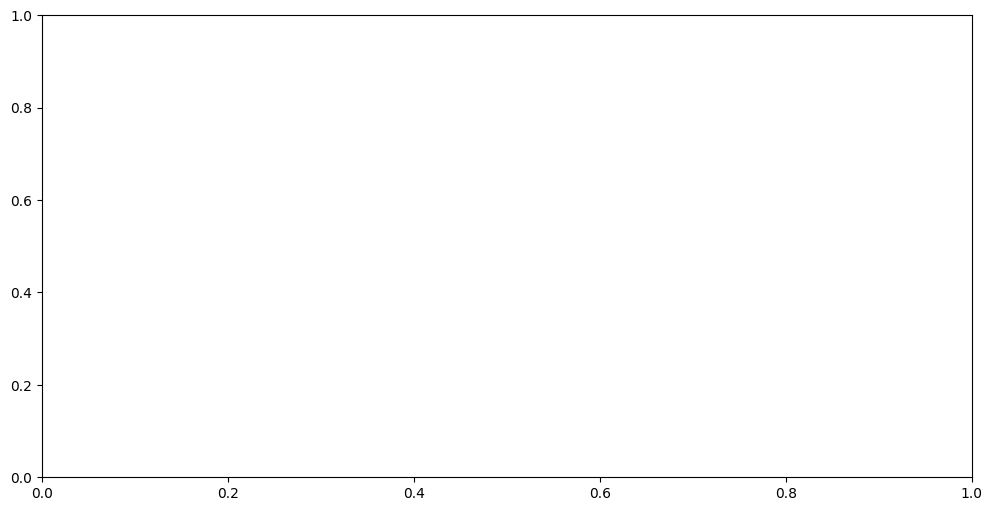

In [ ]:
future_days = 50  # Numero di giorni futuri da prevedere
last_window = np.copy(x_test[-1:])  # Prende l'ultima finestra

future_predictions = []  # Lista per salvare le predizioni future

for i in range(future_days):
    next_pred = model.predict(last_window)  # Predizione per tutti i titoli
    future_predictions.append(next_pred.flatten())  # Salva i 5 valori previsti

    # Shift della finestra temporale
    last_window = np.roll(last_window, shift=-1, axis=1)
    last_window[0, -1, :] = next_pred  # Inserisce la nuova predizione all'ultimo posto

# Converti le predizioni alla scala originale
future_predictions = np.array(future_predictions)

# Creazione del grafico per ogni titolo
fig, ax = plt.subplots(figsize=(12, 6))

# Plotta i dati originali
for i, col in enumerate(data.columns):  
    ax.plot(range(len(data)), data[col], label=f"Dati originali - {col}")

# Plotta le predizioni future per ogni titolo
for i, col in enumerate(data.columns):  
    ax.plot(range(len(data), len(data) + future_days), 
            future_predictions[:, i], 'r+:', label=f"Predizione {col}")

ax.axvline(x=len(data), color='purple', linestyle='--', label="Inizio Predizione")  
ax.set_title(f"Predizione per i prossimi {future_days} giorni")
ax.legend()
plt.show()
